In [1]:
# 读训练数据(所有井存一起)，去除坏数据
import os
import pandas as pd
import numpy as np

# 文件夹路径
folder_path = 'E:\\code\BiLSTM\\BiLSTM\\train'
# folder_path = 'E:\\code\BiLSTM\\BiLSTM\\test'

# target_column = ["DZL", "ZRGM"]
all_data = np.array([])

# 遍历文件夹下的每个xlsx文件
for filename in os.listdir(folder_path):
    if filename.endswith('.xlsx'):
        # print(filename)
        file_path = os.path.join(folder_path, filename)

        # 读取Excel文件中的第二个表格
        xls = pd.ExcelFile(file_path)
        sheet_names = xls.sheet_names
        if len(sheet_names) > 1:
            df = pd.read_excel(file_path, sheet_name=sheet_names[1], header=None)

            # 获取第三行数据作为表头
            header = df.iloc[2]

            # 找到标签为"XXX"的列
            md_column = header[header == "DMZKMD"].index[0]
            dzl_column = header[header == "DZL"].index[0]
            zrgm_column = header[header == "ZRGM"].index[0]
            gg_column = header[header == "DMZKGG"].index[0]
            dssc_column = header[header == "DSSC"].index[0]
            zrdw_column = header[header == "ZRDW"].index[0]

            # 提取对应列的数据
            md_data = df.iloc[3:, md_column].values
            dzl_data = df.iloc[3:, dzl_column].values
            zrgm_data = df.iloc[3:, zrgm_column].values
            gg_data = df.iloc[3:, gg_column].values
            dssc_data = df.iloc[3:, dssc_column].values
            zrdw_data = df.iloc[3:, zrdw_column].values

            # 清洗数据：将列转换为数值类型
            md_data = pd.to_numeric(md_data, errors='coerce')
            dzl_data = pd.to_numeric(dzl_data, errors='coerce')
            zrgm_data = pd.to_numeric(zrgm_data, errors='coerce')
            gg_data = pd.to_numeric(gg_data, errors='coerce')
            dssc_data = pd.to_numeric(dssc_data, errors='coerce')
            zrdw_data = pd.to_numeric(zrdw_data, errors='coerce')

            # 将数据存储到NumPy数组中
            well_train_data = []
            if len(md_data) > 0 and len(dzl_data) > 0 and len(zrgm_data) > 0 and len(gg_data) > 0 and len(dssc_data) > 0 and len(zrdw_data) > 0:
                well_train_data = np.array([md_data, dzl_data, zrgm_data, gg_data, dssc_data, zrdw_data])

            # 检测有缺失值的列并创建布尔索引
            mask = np.isnan(well_train_data).any(axis=0)
            # 使用布尔索引选择不包含缺失值的列
            well_train_data = well_train_data[:, ~mask]

            # 找到开头和结尾处的"0"值所在列
            start_indices = 0
            end_indices= len(well_train_data[0]) - 1
            while start_indices <= end_indices and np.any(well_train_data[:, start_indices] == 0):
                start_indices += 1
            while end_indices >= start_indices and np.any(well_train_data[:, end_indices] == 0):
                end_indices -= 1
            min_columns = end_indices - start_indices + 1

            # 将剔除开头结尾处"0"值的数据存储到新的NumPy数组中
            new_well_train_data = []
            if start_indices <= end_indices:
                for i in range(len(well_train_data)):
                    new_well_train_data.append(well_train_data[i][start_indices:end_indices + 1])

            new_well_train_data = np.array(new_well_train_data)

            if all_data.size == 0:
                all_data = new_well_train_data
            else:
                all_data = np.concatenate((all_data, new_well_train_data), axis=1)

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'E:\\code\\BiLSTM\\BiLSTM\\train'

In [ ]:
# 数据进行小波变换
import numpy as np
import pywt

reconstructed_all_data = []
for data in all_data:
    wavelet = 'db4'  # 选择小波基函数，这里使用Haar小波
    coeffs = pywt.wavedec(data, wavelet)

    # 设置截断级别（保留前N个系数）
    truncate_level = 5  # 表示保留到第4级小波系数
    coeffs[truncate_level+1:] = [np.zeros_like(coeff) for coeff in coeffs[truncate_level+1:]]

    # 进行逆小波变换以重构信号
    reconstructed_all_data.append(pywt.waverec(coeffs, wavelet))

reconstructed_all_data = np.array(reconstructed_all_data)

In [ ]:
reconstructed_train_data = reconstructed_all_data

In [ ]:
reconstructed_test_data = reconstructed_all_data

IndexError: index 0 is out of bounds for axis 0 with size 0

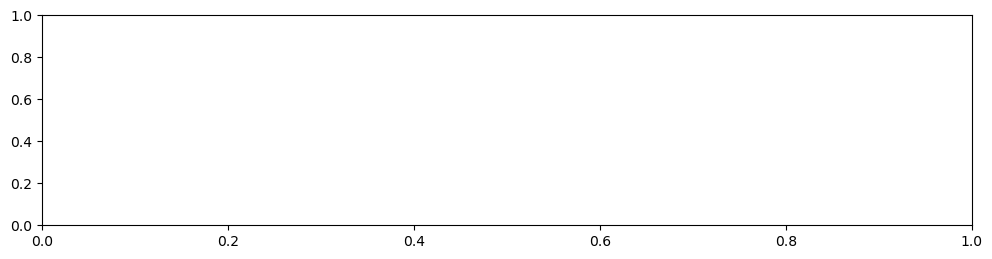

In [2]:
import matplotlib.pyplot as plt

# 绘制原始信号和重构信号
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(all_data[0])
plt.title('原始信号')
plt.subplot(2, 1, 2)
plt.plot(reconstructed_test_data[0])
plt.title('重构信号（截断小波系数）')

# 显示图表
plt.tight_layout()
plt.show()

In [ ]:
# 找测试井每类属性的最大最小值
min_vals = []
max_vals = []
# 遍历每列属性寻找最大最小值
for row1, row2 in zip(all_data, reconstructed_all_data):
    min_val1 = np.min(row1, axis=0)
    min_val2 = np.min(row2, axis=0)
    max_val1 = np.max(row1, axis=0)
    max_val2 = np.max(row2, axis=0)

    min_val = min(min_val1, min_val2)
    max_val = max(max_val1, max_val2)

    min_vals.append(min_val)
    max_vals.append(max_val)

In [3]:
# 剔除训练数据中的异常值
new_all_train_data = reconstructed_train_data.T
rows_to_delete = []
num = 0
for i in range(new_all_train_data.shape[0]):
    if not (min_vals[0] <= new_all_train_data[i, 0] <= max_vals[0]) or not (min_vals[1] <= new_all_train_data[i, 1] <= max_vals[1]) or not (min_vals[2] <= new_all_train_data[i, 2] <= max_vals[2]) or not (min_vals[3] <= new_all_train_data[i, 3] <= max_vals[3]) or not (min_vals[4] <= new_all_train_data[i, 4] <= max_vals[4]) or not (min_vals[5] <= new_all_train_data[i, 5] <= max_vals[5]):
        num += 1
        rows_to_delete.append(i)


new_all_train_data = np.delete(new_all_train_data, rows_to_delete, axis=0)

new_all_train_data = new_all_train_data.T

NameError: name 'reconstructed_train_data' is not defined

In [4]:
# 训练数据灰度化
# 定义灰度尺度
g = 512

gray_all_train_data = []
# 遍历每列属性并进行灰度化处理
for i, column_data in enumerate(new_all_train_data):
    # 计算灰度化后的值
    gray_column_data = np.minimum(np.floor((column_data - min_vals[i]) * g / (max_vals[i] - min_vals[i])), g - 1)

    gray_all_train_data.append(gray_column_data)

gray_all_train_data = np.array(gray_all_train_data)

NameError: name 'new_all_train_data' is not defined

In [5]:
# 计算水平方向上的梯度
gradient_all_train_data = np.diff(gray_all_train_data, axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [6]:
# 提取梯度共生矩阵
import numpy as np

# 存储所有井连接后的梯度共生矩阵
all_glcm = []

# 遍历灰度化后的两列属性，计算 GLCM
# 初始化两条曲线间的梯度共生矩阵
md_dzl_glcm = np.zeros((g*2 - 1, g*2 - 1), dtype=np.int32)
md_zrgm_glcm = np.zeros((g*2 - 1, g*2 - 1), dtype=np.int32)
md_gg_glcm = np.zeros((g*2 - 1, g*2 - 1), dtype=np.int32)
md_dssc_glcm = np.zeros((g*2 - 1, g*2 - 1), dtype=np.int32)
md_zrdw_glcm = np.zeros((g*2 - 1, g*2 - 1), dtype=np.int32)

md_column = gradient_all_train_data[0]
dzl_column = gradient_all_train_data[1]
zrgm_column = gradient_all_train_data[2]
gg_column = gradient_all_train_data[3]
dssc_column = gradient_all_train_data[4]
zrdw_column = gradient_all_train_data[5]

# 提取md和dzl间的梯度共生矩阵
for i in range(len(md_column)):
    x = int(md_column[i])
    y = int(dzl_column[i])

    # 确保坐标在范围内
    if -g <= x < g and -g <= y < g:
        md_dzl_glcm[x + 511, y + 511] += 1

# 提取md和zrgm间的梯度共生矩阵
for i in range(len(md_column)):
    x = int(md_column[i])
    y = int(zrgm_column[i])

    # 确保坐标在范围内
    if -g <= x < g and -g <= y < g:
        md_zrgm_glcm[x + 511, y  + 511] += 1

# 提取md和gg间的梯度共生矩阵
for i in range(len(md_column)):
    x = int(md_column[i])
    y = int(gg_column[i])

    # 确保坐标在范围内
    if -g <= x < g and -g <= y < g:
        md_gg_glcm[x + 511, y + 511] += 1

# 提取md和dssc间的梯度共生矩阵
for i in range(len(md_column)):
    x = int(md_column[i])
    y = int(dssc_column[i])

    # 确保坐标在范围内
    if -g <= x < g and -g <= y < g:
        md_dssc_glcm[x + 511, y + 511] += 1

# 提取md和zrdw间的梯度共生矩阵
for i in range(len(md_column)):
    x = int(md_column[i])
    y = int(zrdw_column[i])

    # 确保坐标在范围内
    if -g <= x < g and -g <= y < g:
        md_zrdw_glcm[x + 511, y + 511] += 1

# 对 GLCM 进行归一化，以计算概率
# dzl_zrgm_glcm_normalized = dzl_zrgm_glcm / np.sum(well_glcm)
# well_glcm.append(dzl_zrgm_glcm_normalized)
all_glcm.append(md_dzl_glcm)
all_glcm.append(md_zrgm_glcm)
all_glcm.append(md_gg_glcm)
all_glcm.append(md_dssc_glcm)
all_glcm.append(md_zrdw_glcm)

# all_glcm 现在包含了每两列属性之间的梯度共生矩阵
all_glcm = np.array(all_glcm)

total = 0
# for row in all_glcm[0]:
#     print(row)
#
for i in range(len(all_glcm[1])):
    for j in range(len(all_glcm[1][i])):
        if all_glcm[1][i][j] != 0:
            total += all_glcm[1][i][j]

NameError: name 'gradient_all_train_data' is not defined

In [7]:
# 根据梯度共生矩阵提取梯度共生关系
import numpy as np

# 存储所有井的梯度共生关系
all_srm = []
for one_glcm in all_glcm:
    # 查找每行中最大值所在的列的索引，如果最大值为"0"，则返回列索引为"-512"
    result_indices = []
    # 遍历每行
    for row in one_glcm:
        max_value = np.max(row)
        if max_value == 0:
            result_indices.append(-512)
        else:
            max_index = np.argmax(row) - 511
            result_indices.append(max_index)
    all_srm.append(result_indices)

all_srm = np.array(all_srm)

In [8]:
all_srm_t = all_srm.T

In [9]:
# 测试数据 x值灰度梯度化
gradient_test_data_x = []

# 遍历每列属性并进行灰度梯度化处理
for i, column_data in enumerate(reconstructed_test_data[1:]):
    print(np.min(column_data, axis=0))
    print(np.max(column_data, axis=0))
    # 计算灰度梯度化后的值
    gray_column_data = np.minimum(np.floor((column_data - min_vals[i + 1]) * g / (max_vals[i + 1] - min_vals[i + 1])), g - 1)
    gradient_column_data = np.diff(gray_column_data)

    gradient_test_data_x.append(gradient_column_data)

gradient_test_data_x = np.array(gradient_test_data_x)
gradient_test_data_x = gradient_test_data_x.T

NameError: name 'reconstructed_test_data' is not defined

In [10]:
# 测试井y属性灰度梯度值复原
# 初始化相关性结果数组
correlation_results = []

# 遍历数组A中的每一行
for row_A in gradient_test_data_x:
    max_corr = 512  # 初始化最高相关性为负数
    max_corr_index = -512  # 初始化最高相关性的行索引为-1

    # 遍历数组B中的每一行
    for i, row_B in enumerate(all_srm_t):
        # 检查B中的行是否全为-1，如果是则跳过该行
        if np.all(row_B == -512):
            continue

        # 计算两行之间的相关性
        corr = np.mean(np.abs(row_A - row_B))
        # corr = np.corrcoef(row_A, row_B)[0, 1]
        print(corr)

        # 如果找到更高的相关性，则更新相关性和行索引
        if corr < max_corr:
            max_corr = corr
            max_corr_index = i - 511

    print("===========")

    # 将最高相关性的行索引添加到结果数组中
    correlation_results.append(max_corr_index)

correlation_results.append(correlation_results[-1])
correlation_results = np.array(correlation_results)

IndexError: list index out of range

In [11]:
# 测试数据 y值灰度梯度化
gray_test_data_y = []

min_val = np.min(all_data[0])
max_val = np.max(all_data[0])

# 计算灰度化后的值
# gray_column_data_y = np.minimum(np.floor((reconstructed_test_data[0] - min_vals[0]) * g / (max_vals[0] - min_vals[0])), g - 1)
gray_column_data_y = np.minimum(np.floor((all_data[0] - min_val) * g / (max_val - min_val)), g - 1)
gradient_column_data_y = np.diff(gray_column_data_y)
gradient_column_data_y = np.append(gradient_column_data_y, gradient_column_data_y[-1])

IndexError: index 0 is out of bounds for axis 0 with size 0

In [12]:
# 将灰度复原结果恢复成测井值
# 读取保存了灰度复原结果的文件
file_path1 = 'E:\\code\BiLSTM\\BiLSTM\\res\\A2：grey_predict_data_DSX.xlsx'
file_path2 = 'E:\\code\BiLSTM\\BiLSTM\\res\\A2：grey_predict_data_SBET.xlsx'
df1 = pd.read_excel(file_path1)
df2 = pd.read_excel(file_path2)


# 提取第一列的数据到NumPy数组
grey_data1 = df1.iloc[:, 0].values
grey_data2 = df2.iloc[:, 0].values

max_grey_gradient = np.max(gradient_column_data_y)
min_grey_gradient = np.min(gradient_column_data_y)


# 将梯度复原结果用于曲线复原 (max_vals[0] - min_vals[0]) / g + min_vals[0]
recover_column_data_y1 = (grey_data1 +  gradient_column_data_y[:len(grey_data1)]/(max_grey_gradient - min_grey_gradient)) * (3.13 - 1.52) / g + 1.52
recover_column_data_y2 = (grey_data2 +  gradient_column_data_y[len(grey_data1):]/(max_grey_gradient - min_grey_gradient)) * (2.55 - 1.35) / g + 1.35 + 0.18

wavelet = 'db4'  # 选择小波基函数
coeffs1 = pywt.wavedec(recover_column_data_y1, wavelet)
coeffs2 = pywt.wavedec(recover_column_data_y2, wavelet)

# 设置截断级别（保留前N个系数）
truncate_level = 4  # 表示保留到第4级小波系数
coeffs1[truncate_level+1:] = [np.zeros_like(coeff) for coeff in coeffs1[truncate_level+1:]]
coeffs2[truncate_level+2:] = [np.zeros_like(coeff) for coeff in coeffs2[truncate_level+2:]]

# 进行逆小波变换以重构信号
recover_column_data_y1 = pywt.waverec(coeffs1, wavelet)[:len(grey_data1)]
recover_column_data_y2 = pywt.waverec(coeffs2, wavelet)[:len(grey_data2)]

recover_column_data_y = np.concatenate([recover_column_data_y1, recover_column_data_y2])

# 绘制原始信号和重构信号
plt.figure(figsize=(20, 6))
plt.subplot(1, 1, 1)
plt.plot(recover_column_data_y, color='b')
plt.plot(all_data[0], color='r')

# 显示图表
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\code\\BiLSTM\\BiLSTM\\res\\A2：grey_predict_data_DSX.xlsx'

In [13]:
import pandas as pd

# 创建一个 Pandas 数据框
df = pd.DataFrame({'Predict': recover_column_data_y, 'True': all_data[0]})

# 指定要保存的 Excel 文件名
excel_file = '../res/gradient_recover_predict_data.xlsx'

# 将数据框保存为 Excel 文件
df.to_excel(excel_file, index=False)

print("数据已保存到 Excel 文件:", excel_file)

NameError: name 'recover_column_data_y' is not defined